In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV #LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV,

In [2]:
public_private_X = pd.read_csv('../Datasets/public_private_X.csv')
sample_submission = pd.read_csv('../Datasets/sample_submission.csv')
train_X = pd.read_csv('../Datasets/train_X.csv')
train_y = pd.read_csv('../Datasets/train_y.csv')

## 1) Data Preprocessing

I visualized each column individually as a histogram using sns. I processed each column based on its histogram. I dropped columns where all values were the same, binned some of the columns, transformed columns with a skewed distribution, and imputed values into columns with missingness. I then determined the variance inflation factor of each column using statsmodels, iteratively dropping the column with the highest VIF until I have dropped four columns.  

In [3]:
def preprocess(df_in, drop_unsure_cat = False):
    df = df_in.copy()
    
    #Drop columns with no information
    df.drop(columns = ['ID', 'DIVISION_CODE', 'RESERVABLE_INDICATOR', 'PRODUCT_STATUS'], inplace = True)
    
    #Bin some of the columns
    df['PURCHASE_ORDER_DUE_DATE'] = pd.qcut(pd.to_datetime(df['PURCHASE_ORDER_DUE_DATE']), 25, retbins = True, labels = list(range(1, 51, 2)))[0]
    df['GIVEN_TIME_TO_LEAD_RATIO'] = pd.cut(df['GIVEN_TIME_TO_LEAD_TIME_RATIO'], bins = [-10000, 0.999, 1.0001, 10000], labels = ['small', 'one', 'high'], retbins = True)[0]
    df['AVERAGE_VENDOR_ORDER_CYCLE_DAYS'] = pd.cut(df['AVERAGE_VENDOR_ORDER_CYCLE_DAYS'],bins = [-1, 6.9, 7.1, 14, 500], labels = [0, 1, 2, 3], retbins = True)[0]
    df['AVERAGE_ORDER_CYCLE_DAYS'] = pd.cut(df['AVERAGE_ORDER_CYCLE_DAYS'], bins = [-1, 6.9, 7.1, 14, 1_000], labels = [0, 1, 2, 3], retbins = True)[0]
    df['LEAD_TIME_TO_DISTANCE_RATIO'] = pd.qcut(df['LEAD_TIME_TO_DISTANCE_RATIO'], 10, retbins = True, labels = list(range(1, 11)))[0]

    #Transform skewed columns (all are right skewed, I determined which was the best form using scipy.stats.skew)
    df['DISTANCE_IN_MILES'] = np.sqrt(df['DISTANCE_IN_MILES'])
    df['AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'] = np.log(df['AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'])
    df['ORDER_QUANTITY_DEVIATION'] = np.sqrt(df['ORDER_QUANTITY_DEVIATION'])
    df['PURCHASING_LEAD_TIME'] = np.log(df['PURCHASING_LEAD_TIME'])
    df['DAYS_BETWEEN_ORDER_AND_DUE_DATE'] = df['DAYS_BETWEEN_ORDER_AND_DUE_DATE'] ** (1/3)
    df['AVERAGE_DAILY_DEMAND_CASES'] = np.log(df['AVERAGE_DAILY_DEMAND_CASES'])
    df['AVERAGE_ORDER_CYCLE_CASES'] = np.log(df['AVERAGE_ORDER_CYCLE_CASES'])

    #Transform and then bin
    df['TRANSIT_LEAD_TIME'] =  df['TRANSIT_LEAD_TIME'] ** (1/3)
    df['TRANSIT_LEAD_TIME'] = pd.cut(df['TRANSIT_LEAD_TIME'], bins = [-0.1, 0.9, 2, 10], labels = ['zero', 'low', 'high'], retbins = True)[0]

    #Impute some columns (using median imputation for all)
    colums_to_median_impute = ['AVERAGE_DAILY_DEMAND_CASES', 'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_CASES']
    for col in  colums_to_median_impute:
        median = np.median(df.loc[~df[col].isna(), col])
        df.loc[df[col].isna(), col] = median

    #Making new variables
    vendor_size_dict = df['PURCHASE_FROM_VENDOR'].value_counts().to_dict()
    df['VENDOR_SIZE'] = df['PURCHASE_FROM_VENDOR'].apply(lambda x: vendor_size_dict[x])
    product_popularity_dict = df['PRODUCT_MARKET'].value_counts().to_dict()
    df['PRODUCT_MARKET'].apply(lambda x: product_popularity_dict[x])
    df.drop(columns = ['PURCHASE_FROM_VENDOR', 'PRODUCT_MARKET'], inplace = True)

    if drop_unsure_cat:
        df.drop(columns = ['PRODUCT_CLASSIFICATION', 'COMPANY_VENDOR_NUMBER', 'SHIP_FROM_VENDOR'], inplace = True) # also 'ORDER_DATE' but I drop that later

    #After VIF on numeric columns only, dropping the first 4 highest VIFs (iteratively determined)
    df.drop(columns = ['DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'DIVISION_NUMBER', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'AVERAGE_ORDER_CYCLE_CASES'], inplace = True)
    
    #Drop because I can't do much with a timestamp dtype, also I don't want to deal with time analysis
    df.drop(columns = 'ORDER_DATE', inplace = True)
    return df


In [4]:
# vif_input = preprocess(train_X).select_dtypes(include = 'number')
# vif_input.drop(columns = ['DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'DIVISION_NUMBER', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'AVERAGE_ORDER_CYCLE_CASES', 'ORDER_QUANTITY_DEVIATION', 'PURCHASING_LEAD_TIME', 'COMPANY_VENDOR_NUMBER'], inplace = True)


# vif_data = pd.DataFrame()
# vif_data["Feature"] = vif_input.columns
# vif_data["VIF"] = [variance_inflation_factor(vif_input.values, i) for i in range(vif_input.shape[1])]


# vif_data.sort_values(by = 'VIF', ascending = False)

In [5]:
# train_complete = pd.merge(train_X, train_y)
train_complete = preprocess(train_X)

## 2) Feature Engineering

Techniques used to create meaningful features

The code for these is included under the processing function. I am creating two new features:
- VENDOR_SIZE: from PURCHASE_FROM_VENDOR ('the vendor from whom the product is purchased'), how large is the company from which the product is purchased?
    - And I will drop the original PURCHASE_FROM_VENDOR column because I think these are just vendor IDs. Seems too large to be treated as categorical but also it would be inappropriate to treat this as continuous/numerical
- PRODUCT_POPULARITY: from PRODUCT_MARKET 'A combination of DIV_NBR and PROD_NBR, representing a product in a specific market', but turn this into how common this specific product is in this specific market
    - I also am dropping this column for the same reason as listed above

## 3) Developing the Model

First, I want to run a statsmodel.api model so that I can measure the VIF of all of the numeric columns. I want to drop the columns with the highest VIF in order to limit the effects of multicolinearity. I iteratively dropped the column with the highest VIF and then recalculated VIFs for each column. From this, I am dropping the first four columns ['DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'DIVISION_NUMBER', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'AVERAGE_ORDER_CYCLE_CASES']. This is included in the preprocessing() function.  

Though in order for all numeric columns to have a VIF below 5, I would also have to drop ['ORDER_QUANTITY_DEVIATION', 'PURCHASING_LEAD_TIME', 'COMPANY_VENDOR_NUMBER']

## 4) Model Fine Tuning

Including cross-validation, regularization, and hyperparameter tuning, etc

In [6]:
cat_columns = ['ORDER_DAY_OF_WEEK', 'PURCHASE_ORDER_TYPE', 'TRANSIT_LEAD_TIME', 'GIVEN_TIME_TO_LEAD_RATIO', 'DUE_DATE_WEEKDAY']
    #also 'DIVISION_NUMBER' but I dropped this from VIF
def encode(df, train = False):
    df_2 = df.copy()
    ohe = OneHotEncoder(drop = 'first')
    ohe.fit(df_2.loc[:, cat_columns])
    encoded = pd.DataFrame(ohe.transform(df.loc[:, cat_columns]).toarray())
    encoded.columns = ohe.get_feature_names_out()
    # if train:
    #     df_2.drop(columns = 'ON_TIME_AND_COMPLETE')
    return pd.concat([df_2.drop(columns = cat_columns), encoded], axis = 1)
    



In [10]:
encoded = encode(train_complete)
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(encoded)
train_poly = pd.DataFrame(poly.transform(encoded))
train_poly.columns = poly.get_feature_names_out()

#Keep only the columns necessary, from l1 regularization
with open('features_to_keep.txt') as features:
    keep = [line.strip() for line in features.readlines()]
train_poly = train_poly.loc[:, keep]

In [11]:
scaler = StandardScaler().fit(train_poly)
train_scaled = pd.DataFrame(scaler.transform(train_poly))
train_scaled.columns = scaler.get_feature_names_out()

In [12]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
model = LogisticRegressionCV(Cs = np.linspace(0.0001, 10, 20), solver = 'saga', penalty = 'elasticnet', max_iter = 1000, 
                             l1_ratios=np.linspace(0, 1, 20)).fit(train_scaled, train_y['ON_TIME_AND_COMPLETE'])

In [16]:
model.C_

array([0.52641053])

In [17]:
model.l1_ratio_

array([0.21052632])

In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [26]:
#Creating a ROC-AUC curve
y_scores = model.predict_proba(train_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(train_y['ON_TIME_AND_COMPLETE'], y_scores)
roc_auc = auc(fpr, tpr)

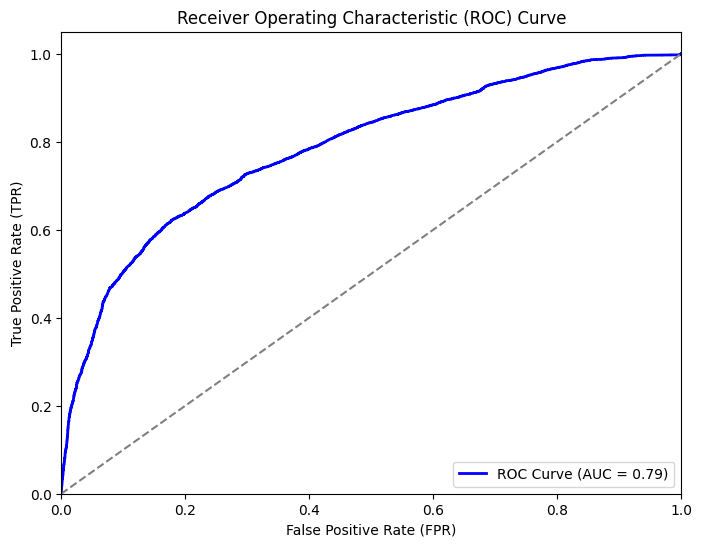

ROC-AUC Score: 0.79


In [27]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f'ROC-AUC Score: {roc_auc:.2f}')

In [14]:
coeffs = pd.DataFrame()
coeffs['Feature'] = model.feature_names_in_
coeffs['Val'] = model.coef_[0]
coeffs['Abs_Val'] = np.abs(coeffs['Val'])
coeffs.sort_values(by = 'Abs_Val', ascending = False)

,Feature,Val,Abs_Val
5,VENDOR_SIZE DUE_DATE_WEEKDAY_4,0.718144,0.718144
28,VENDOR_SIZE DUE_DATE_WEEKDAY_4^2,0.718144,0.718144
18,PURCHASING_LEAD_TIME VENDOR_SIZE DUE_DATE_WEEK...,-0.689007,0.689007
26,VENDOR_SIZE PURCHASE_ORDER_TYPE_1 DUE_DATE_WEE...,-0.601067,0.601067
25,VENDOR_SIZE^2 DUE_DATE_WEEKDAY_4,-0.564529,0.564529
0,COMPANY_VENDOR_NUMBER PRODUCT_CLASSIFICATION,-0.517017,0.517017
2,ORDER_QUANTITY_DEVIATION PURCHASING_LEAD_TIME,-0.461969,0.461969
4,AVERAGE_ORDER_CYCLE_DAYS^2,-0.454838,0.454838
7,COMPANY_VENDOR_NUMBER PRODUCT_CLASSIFICATION^2,0.399552,0.399552
16,ORDER_QUANTITY_DEVIATION AVERAGE_ORDER_CYCLE_D...,0.390114,0.390114


For feature selection, I ran LogisticRegressionCV with 5-fold splitting, a C-value of 0.001, 'sava' solver, 'l1' penalty, and a max_iter of 1000. I saved all of the features that weren't regularized down to 0 in a file called features_to_keep.txt. Only 32 of the 5455 original features (3rd order polynomial terms and their interactions) are maintained.
The model from this process has a training accuracy of 70.9, test accuracy of 70.89.

Next, rerunning LogisticRegressionCV with elastic net penalties, l1 ratios of [0.25, 0.5, 0.75] and 8 different options for C values, and a 10-fold splitting strategy. The best C-value was 0.1 and the best l1-ratio was 0.5 (equal l1 and l2 penalties).
This model has a training accuracy of 0.728 and a test accuracy of 0.7415

Next, having more options for Cs (np.linspace(0.0001, 10, 20)) and l1_ratios (l1_ratios=np.linspace(0, 1, 20)). The best C-value is 1.57903158 and the best l1-ratio is 0 (all l2 penalty).

This model has a training accuracy of 0.729 and a test accuracy of 0.7444.
Note that the feature VENDOR_SIZE that I created has the largest coefficient here.

In determining the optimal threshold, I tried model.predict_proba on 100 different threshold values, finding that 0.49 is the optimal threshold but only nominally better than 0.5 – so I will be keeping the default threshold of 0.5 for the sake of convenience.

Retrying this cross-validation, the best C-value is 0.52641053 and the l1-ratio is 0.21052632. The training accuracy is 0.7222 and the test accuracy is 0.735.

In [18]:
# y_train_pred = pipeline.predict(train_transformed)
y_train_pred = model.predict(train_scaled)
accuracy = accuracy_score(train_y['ON_TIME_AND_COMPLETE'], y_train_pred)
print("Train Accuracy:", accuracy)

Train Accuracy: 0.7222358301082643


In [23]:
thresh_accuracies = []
for threshold in np.linspace(0.2, 0.8, 100):
    predicted_probs = model.predict_proba(train_scaled)[:, 1]
    train_predict = (predicted_probs >= threshold).astype(int)
    thresh_accuracies.append(accuracy_score(train_y['ON_TIME_AND_COMPLETE'], train_predict))

accuracies = pd.DataFrame()
accuracies['Threshold'] = np.linspace(0.2, 0.8, 100)
accuracies['Accuracy'] = thresh_accuracies

accuracies.sort_values(by = 'Accuracy', ascending = False).head()

,Threshold,Accuracy
51,0.509091,0.724097
52,0.515152,0.723412
53,0.521212,0.722824
50,0.503030,0.722628
54,0.527273,0.722285


# Generate Prediction

In [19]:
#Apply the same transformations to the test set
test_preprocessed = preprocess(public_private_X)
#Issue that PURCHASE_ORDER_DUE_DATE has duplicate edges
    #Originally 50 bins, I'm making it 25 but the labels are counting by 2
test_encoded = encode(test_preprocessed)
test_poly = pd.DataFrame(poly.transform(test_encoded))
test_poly.columns = poly.get_feature_names_out()
test_poly = test_poly.loc[:, keep]

test_scaled = pd.DataFrame(scaler.transform(test_poly))
test_scaled.columns = scaler.get_feature_names_out()

In [20]:
y_pred_test = model.predict(test_scaled)

submission = pd.DataFrame()
submission['ID'] = public_private_X['ID']
submission['ON_TIME_AND_COMPLETE'] = y_pred_test
submission.to_csv('Submissions/submission7.csv', index = False)

## 5) Key Takeaways (Short Reflection)

* Provide a brief summary of your key takeaways from this prediction problem.
* Reflect on challenges faced and lessons learned from your model building process.

This prediction problem was an excellent practice in combining many of the concepts that we have learned in this class. From it, I could combine the steps of building a model and the metrics that assist with each. I now feel like I have a better understanding of VIF, of cross-validation, of polynomial features, and of threshold tuning.